## Experiment 3: Model Robustness  
This experiment will measure the performance of the models in being able to adapt to large changes in the goal distribution of an agent. We will generate new episode data (~10 episodes) after significantly changing the goal distributions of the agents. We will then measure change in performance from before. 
  
Steps:
  
1. Load agents and data from experiment 0
2. Run the models and get score information
3. Change the goal distributions of the agents
4. Generate new data
5. Run the models and get new score information
6. Visualize the difference

In [1]:
import numpy as np
import pymc
import networkx as nx
import matplotlib.pyplot as plt
import random
import json

In [2]:
import sys
import os
import osmnx as ox

# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [3]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.agents.agent_species import ShortestPathAgent
from real_world_src.simulation.simulator import Simulator
#from real_world_src.simulation.experiment_1 import Simulator

from real_world_src.utils.run_manager import RunManager
from real_world_src.utils.config import VISUAL_CONFIG
from real_world_src.utils.config import get_agent_color

## Step 1: Loading the Data

In [4]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

Started new simulation run #26
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_26_20250505_093610
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges


In [5]:
# Need to establish the set of common goals (just choose the landmark nodes)
goals = [469084068, 49150691, 768264666, 1926666015, 1926673385, 49309735,
         273627682, 445989107, 445992528, 446128310, 1772230346, 1926673336, 
         2872424923, 3139419286, 4037576308]

In [6]:
import pickle
# if you used dill, just replace pickle with dill

with open('agents.pkl', 'rb') as f:
    agents = pickle.load(f)

In [7]:
with open("./data/path_data.json", 'r') as file:
    path_data = json.load(file)

with open("./data/goal_data.json", 'r') as file:
    goal_data = json.load(file)

In [8]:
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(k) if isinstance(k, str) and k.isdigit() else k: convert_keys_to_int(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [convert_keys_to_int(item) for item in data]
    else:
        return data

In [9]:
goal_data = convert_keys_to_int(goal_data)
path_data = convert_keys_to_int(path_data)

## Step 2: Running the Models on Old Data

In [13]:
def brier_score(true_goal, p_dist):
    """
    Multi-class Brier score given a dict goal→prob.
    """
    score = 0.0
    for g, p in p_dist.items():
        y = 1.0 if g == true_goal else 0.0
        score += (p - y) ** 2
    return float(score)


def brier_along_path(path, true_goal, posteriors_by_step, goals):
    """
    Compute Brier scores at 0%, 10%, …, 100% of the path.
    
    Parameters
    ----------
    path : list
        The sequence of states (or state-action tuples).
    true_goal : hashable
        The ground-truth goal for this trajectory.
    posteriors_by_step : dict[int, dict] or list[dict]
        Either
          * a dict mapping step index 1..n → posterior dict, OR
          * a list of posterior dicts in step-order (len = n).
        Each posterior dict maps each goal → P(goal | trajectory up to that step).
    
    Returns
    -------
    dict[float, float]
        Mapping fraction → Brier score.
    """
    n = len(path) - 1
    if n < 1:
        raise ValueError("Path must have at least 2 states to define transitions")

    # uniform prior for t=0
    uniform = {g: 1.0/len(goals) for g in goals}

    results = []
    for frac in np.linspace(0, 1, 11):  # 0.0,0.1,...,1.0
        t = int(np.floor(frac * n))
        if t == 0:
            p_dist = uniform
        else:
            p_dist = posteriors_by_step[t-1]
        results.append(brier_score(true_goal, p_dist))

    return results

In [10]:
# Import BToM baseline
from real_world_src.models.btom import BToM

In [11]:
btom = BToM(campus, agents, goals)

Computing shortest paths...
Done


In [12]:
# Calculate all the posteriors using the first 30 episode
posteriors_data = {}

for episode in range(len(goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, path_data[episode][agent.id])
    # Reset the posteriors for new episode
    btom.reset_posteriors()

In [16]:
orig_scores = []
for episode in range(len(goal_data)):
    for agent in agents:
        orig_scores.append(brier_along_path(path_data[episode][agent.id], 
                                  goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))


## Step 3: Change Agent Goal Distributions

In [17]:
def kl_divergence(p, q, eps=1e-12):
    """
    Compute KL divergence KL(p || q) = sum_i p[i] * log(p[i] / q[i]).
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)
    # add epsilon and renormalize (optional, but keeps them valid dists)
    p = p + eps
    q = q + eps
    p = p / p.sum()
    q = q / q.sum()
    return float(np.sum(p * np.log(p / q)))

In [21]:
n_goals = len(goals)
ag_alpha = np.random.normal(1, 0.2, size=n_goals)

for agent in agents: # Set each agent's goal distribution
    while True:
        old_distribution = agent.goal_distribution
        new_distribution = np.random.dirichlet(alpha=np.ones(n_goals)*(ag_alpha), size=1)[0]
        if kl_divergence(old_distribution, new_distribution) > 1:
            agent.goal_distribution = new_distribution
            break


## Step 4: Generate New Data

In [23]:
import json

In [22]:
def new_episode(agents):

    # Set the goal and start nodes
    for agent in agents:
        agent.path = [] # Clear the old path
        agent.goal_node = int(np.random.choice(goals, size=1, p=agent.goal_distribution)[0])

        while True:
            start_node = campus.get_random_node()
            try:
                path = nx.shortest_path(campus.G_undirected, 
                                       source=start_node, 
                                       target=agent.goal_node, 
                                       weight='length')
                if len(path) >15:  # Make sure path is non-trivial
                    break
            except:
                continue
        agent.start_node = start_node
        agent.current_node = start_node

    return 

In [37]:
new_path_data = {}
new_goal_data = {}
m = 50
for episode in range(m):
    new_episode(agents)
    episode_path_data = {}
    episode_goal_data = {}
    for agent in agents:
        agent.plan_path()
        episode_path_data[agent.id] = agent.path
        episode_goal_data[agent.id] = agent.goal_node
    # Save the data from each episode
    new_path_data[episode] = episode_path_data
    new_goal_data[episode] = episode_goal_data

with open("./data/new_path_data.json", "w") as file:
    json.dump(new_path_data, file, indent=4)

with open("./data/new_goal_data.json", "w") as file:
    json.dump(new_goal_data, file, indent=4)

In [43]:
with open("./data/new_path_data.json", 'r') as file:
    new_path_data = json.load(file)

with open("./data/new_goal_data.json", 'r') as file:
    new_goal_data = json.load(file)

In [44]:
new_goal_data = convert_keys_to_int(new_goal_data)
new_path_data = convert_keys_to_int(new_path_data)

In [45]:
len(new_goal_data)

50

## Step 5: Run Models on New Data

In [46]:
posteriors_data = {}

for episode in range(len(new_goal_data)):
    posteriors_data[episode] = {}
    for agent in agents:
        posteriors_data[episode][agent.id] = btom.update_agent_posterior_over_path(agent, new_path_data[episode][agent.id])
    # Reset the posteriors for new episode
    btom.reset_posteriors()

In [47]:
new_scores = []
for episode in range(len(new_goal_data)):
    for agent in agents:
        new_scores.append(brier_along_path(new_path_data[episode][agent.id], 
                                  new_goal_data[episode][agent.id], 
                                  posteriors_data[episode][agent.id], 
                                  goals))

## Step 6: Visualize Performance Change

In [48]:
len(new_scores), len(orig_scores)

(5000, 10000)

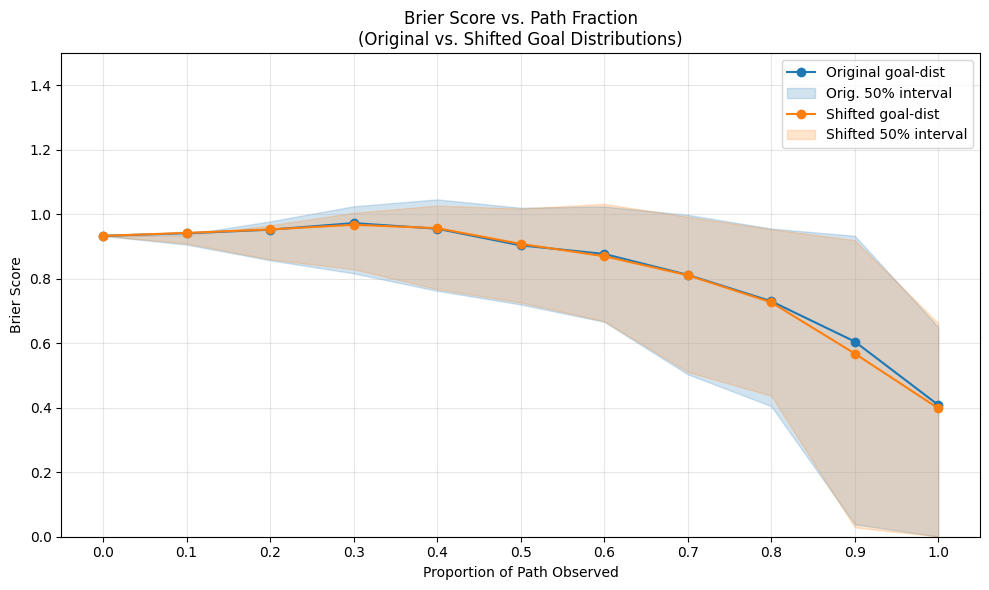

In [50]:
# Convert to arrays
arr_orig = np.array(orig_scores)  # shape (N, n_fractions)
arr_new  = np.array(new_scores)

# Fraction grid (must be the same length as the second axis of your arrays)
props = np.linspace(0, 1, arr_orig.shape[1])

# Compute statistics for original
mean_orig  = arr_orig.mean(axis=0)
low25_orig = np.percentile(arr_orig, 25, axis=0)
high75_orig= np.percentile(arr_orig, 75, axis=0)

# Compute statistics for shifted
mean_new   = arr_new.mean(axis=0)
low25_new  = np.percentile(arr_new, 25, axis=0)
high75_new = np.percentile(arr_new, 75, axis=0)

plt.figure(figsize=(10,6))

# original
plt.plot(props, mean_orig, '-o', label='Original goal‐dist', color='C0')
plt.fill_between(props, low25_orig, high75_orig,
                 color='C0', alpha=0.2, label='Orig. 50% interval')

# shifted
plt.plot(props, mean_new, '-o', label='Shifted goal‐dist', color='C1')
plt.fill_between(props, low25_new, high75_new,
                 color='C1', alpha=0.2, label='Shifted 50% interval')

plt.xlabel('Proportion of Path Observed')
plt.ylabel('Brier Score')
plt.title('Brier Score vs. Path Fraction\n(Original vs. Shifted Goal Distributions)')
plt.xticks(props)
plt.ylim(0, 1.5)
plt.grid(alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

For the BToM model, there is no discernable change to the performance when the goal distribution is shifted. This is exactly to be expected as BToM does not learn historical patterns of the data. It simply updates the posterior based on how actions change the shortest paths to the goals. We should see a noticeable difference for MToM.